In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, losses, optimizers, Input, optimizers
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import time
import os
from time import sleep
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay
import pprint
import pywt
tf.__version__

'2.8.0'

In [2]:
%load_ext tensorboard

In [3]:
start = time.perf_counter()

In [4]:
len(tf.config.list_physical_devices('GPU'))>0

True

In [5]:
device_name = tf.test.gpu_device_name()
print(device_name)

/device:GPU:0


In [6]:
X_x_train = np.loadtxt("./data/X_x_train.txt")
X_y_train = np.loadtxt("./data/X_y_train.txt")
X_z_train = np.loadtxt("./data/X_z_train.txt")
y_train = np.loadtxt("./data/y_train.txt")

X_x_test = np.loadtxt("./data/X_x_test.txt")
X_y_test = np.loadtxt("./data/X_y_test.txt")
X_z_test = np.loadtxt("./data/X_z_test.txt")
y_test = np.loadtxt("./data/y_test.txt")

In [7]:
# for i, r in tqdm(X_x_train[:], total=X_x_train.shape[0], desc="printing graphs..."):
#     print("plot" +str(i))
#     row = X_x_train[i,:-1]
#     y = X_x_train[i,-1:]
#     print(label_names[int(y)-1])
#     plt.plot(row)
#     plt.show()


In [8]:
def standard_score_normalization(x):
    x_m = np.mean(x, axis=1).reshape(-1,1)
    x_std = np.std(x,axis=1).reshape(-1,1)
    return (x-x_m)/x_std

In [9]:
norm = StandardScaler()

In [10]:
X_x_train_norm = norm.fit_transform(X_x_train)
X_y_train_norm = norm.fit_transform(X_y_train)
X_z_train_norm = norm.fit_transform(X_z_train)

X_x_test_norm = norm.fit_transform(X_x_test)
X_y_test_norm = norm.fit_transform(X_y_test)
X_z_test_norm = norm.fit_transform(X_z_test)

### Below I'm comparing two different concatenation functions.

concat_xyz is vectorizing calculations while concat2_xyz is iterating

In [11]:
def concat_xyz(x,y,z):
    data = np.empty((x.shape[0],x.shape[1],3))
#     x = np.expand_dims(x, axis=1) # same as x = x[:,np.newaxis,:]
#     y = np.expand_dims(y, axis=1)
#     z = np.expand_dims(z, axis=1)
    data[:,:,0] = x
    data[:,:,1] = y
    data[:,:,2] = z
    return data

In [12]:
#speed test purposes
def concat2_xyz(x,y,z):
    data = np.empty((x.shape[0],x.shape[1],3))
    for i, rowx,rowy, rowz in zip(range(x.shape[0]),x,y,z):
        data[i,:,0] = rowx.reshape(1,-1)
        data[i,:,1] = rowy.reshape(1,-1)
        data[i,:,2] = rowz.reshape(1,-1)
    return data

In [13]:
tic = time.perf_counter()
X_xyz_norm_train =  concat_xyz(X_x_train_norm,X_y_train_norm, X_z_train_norm)
X_xyz_norm_test = concat_xyz(X_x_test_norm,X_y_test_norm,X_z_test_norm)
toc = time.perf_counter()
print(f"concat_xyz in {toc - tic:0.4f} seconds")

concat_xyz in 0.0084 seconds


In [14]:
#speed test purposes
tic = time.perf_counter()
concat2_xyz(X_x_train_norm,X_y_train_norm, X_z_train_norm)
concat_xyz(X_x_test_norm,X_y_test_norm,X_z_test_norm)
toc = time.perf_counter()
print(f"concat2_xyz in {toc - tic:0.4f} seconds")

concat2_xyz in 0.0150 seconds


#### Vectorizing calculations is faster


In [15]:
label_names = ['Walking', 'Walking upstairs', 'Walking downstairs', 'Sitting', 'Standing', 'Laying']
num_classes = len(label_names)

First I tried this model with one hot encoded y values with catagorical cross entropy but for the confusion matrix I needed the multiclass values instead so during my second iteration I reformatted the model and the data.

In [16]:
# shifting y_train to values from 0 to num_classes-1
y_train = y_train - 1
y_test = y_test - 1

In [17]:
# one hot encoding
y_ohe_train = to_categorical(y_train,num_classes)
y_ohe_test = to_categorical(y_test, num_classes)

In [18]:
X_xyz_norm_train.shape

(7352, 128, 3)

In [19]:
X_xyz_norm_test.shape

(2947, 128, 3)

In [20]:
y_train.shape

(7352,)

In [21]:
y_test.shape

(2947,)

In [22]:
y_ohe_train.shape

(7352, 6)

In [23]:
input_shape = X_xyz_norm_train.shape[1:]

In TF1, placeholder would be needed to get input shape of `(None, 128, 3)` but here we take `(128, 3)` as input shape instead

# Creating Images representing time series data

In [24]:
X_xyz_norm_train_swap = np.swapaxes(X_xyz_norm_train,1,2)

In [25]:
X_xyz_norm_train.shape

(7352, 128, 3)

In [26]:
X_xyz_norm_train_swap.shape

(7352, 3, 128)

### Showing the 1/7352 128-sample run

<function matplotlib.pyplot.show(close=None, block=None)>

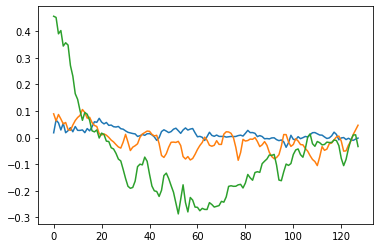

In [27]:
plt.plot(X_xyz_norm_train_swap[0][0])
plt.plot(X_xyz_norm_train_swap[0][1])
plt.plot(X_xyz_norm_train_swap[0][2])
plt.show

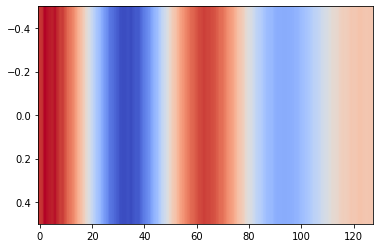

In [28]:
signal = np.sqrt((X_xyz_norm_train_swap[0][0])**2+(X_xyz_norm_train_swap[0][1])**2+(X_xyz_norm_train_swap[0][2])**2)
# samples taken at 50hz
coeffs, freqs = pywt.cwt(signal,50,'morl')
plt.imshow(coeffs, cmap = 'coolwarm', aspect = 'auto')

<H1>Implementing CNN</H1>

In [29]:
cnn = models.Sequential()
cnn.add(layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=input_shape))
# cnn.add(layers.MaxPool1D(pool_size=2))
cnn.add(layers.Flatten())
cnn.add(layers.Dense(100, activation='relu'))
cnn.add(layers.Dense(30, activation='relu'))
cnn.add(layers.Dense(num_classes,activation='softmax'))

In [30]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 127, 64)           448       
                                                                 
 flatten (Flatten)           (None, 8128)              0         
                                                                 
 dense (Dense)               (None, 100)               812900    
                                                                 
 dense_1 (Dense)             (None, 30)                3030      
                                                                 
 dense_2 (Dense)             (None, 6)                 186       
                                                                 
Total params: 816,564
Trainable params: 816,564
Non-trainable params: 0
_________________________________________________________________


In [31]:
# optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
cnn.compile(optimizer="adam",
           loss="categorical_crossentropy",
           metrics="accuracy")

In [32]:
log_dir = "logs/fit/cnn/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
cnn_tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [33]:
cnnhistory = cnn.fit(X_xyz_norm_train, y_ohe_train, epochs=50, batch_size = 10, validation_data=(X_xyz_norm_test, y_ohe_test),callbacks=[cnn_tensorboard_callback])

Epoch 1/50
736/736 [==============================] - 10s 2ms/step - loss: 0.9097 - accuracy: 0.5706 - val_loss: 0.6878 - val_accuracy: 0.7190
Epoch 2/50
736/736 [==============================] - 1s 2ms/step - loss: 0.5716 - accuracy: 0.7371 - val_loss: 0.6209 - val_accuracy: 0.7435
Epoch 3/50
736/736 [==============================] - 1s 2ms/step - loss: 0.4559 - accuracy: 0.7905 - val_loss: 0.7063 - val_accuracy: 0.7234
Epoch 4/50
736/736 [==============================] - 1s 2ms/step - loss: 0.4155 - accuracy: 0.8088 - val_loss: 1.1204 - val_accuracy: 0.6810
Epoch 5/50
736/736 [==============================] - 1s 2ms/step - loss: 0.3877 - accuracy: 0.8271 - val_loss: 0.6088 - val_accuracy: 0.7679
Epoch 6/50
736/736 [==============================] - 1s 2ms/step - loss: 0.3553 - accuracy: 0.8402 - val_loss: 0.7496 - val_accuracy: 0.7340
Epoch 7/50
736/736 [==============================] - 1s 2ms/step - loss: 0.3435 - accuracy: 0.8505 - val_loss: 0.7874 - val_accuracy: 0.7448
Epoch

In [34]:
# %tensorboard --logdir logs/fit/cnn/

To run tensorboard in the cli use command ```tensorboard --logdir logs/fit/cnn/```

In [35]:
# cnn.save("my_model")
# tensorflow_graph = tf.saved_model.load("my_model")
# x = np.random.uniform(size=(4, 32)).astype(np.float32)
# predicted = tensorflow_graph(x).numpy()

In [36]:
# loss_values = cnnhistory.history['loss']
# epochs = range(1, len(loss_values)+1)

# plt.plot(epochs, loss_values, label='Training Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()

# plt.show()

In [37]:
# acc_values = cnnhistory.history['accuracy']
# epochs = range(1, len(loss_values)+1)

# plt.plot(epochs, acc_values, label='Training Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()

# plt.show()

[5 3 4 ... 1 1 1]
[4. 4. 4. ... 1. 1. 1.]


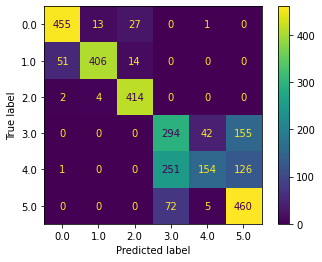

In [38]:
y_pred = np.argmax(cnn.predict(X_xyz_norm_test),axis=1)
print(y_pred)
# print(y_pred.shape)
# y_test_1D = np.argmax(y_test, axis=1).T[0]
# print(type(y_test_1D))
print(y_test)
# print(y_test_1D.shape)
ConfusionMatrixDisplay.from_predictions(y_test,y_pred)

<H1>Implementing LSTM</H1>

In [39]:
# LSTM
lstm = models.Sequential()
lstm.add(layers.LSTM(128,input_shape=input_shape))
lstm.add(layers.Dropout(rate=0.2))
lstm.add(layers.Dense(6,activation="softmax"))

In [40]:
lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               67584     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                                 
Total params: 68,358
Trainable params: 68,358
Non-trainable params: 0
_________________________________________________________________


In [41]:
lstm.compile(optimizer = "adam",
            loss="categorical_crossentropy",
            metrics = "accuracy"
            )

In [42]:
lstm_log_dir = "logs/fit/lstm/lstm" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
lstm_tensorboard_callback = TensorBoard(log_dir=lstm_log_dir, histogram_freq=1)

In [43]:
lstmhistory = lstm.fit(X_xyz_norm_train,y_ohe_train,epochs = 50,batch_size=10,validation_data=(X_xyz_norm_test, y_ohe_test),callbacks=[lstm_tensorboard_callback])

Epoch 1/50
736/736 [==============================] - 14s 11ms/step - loss: 1.5033 - accuracy: 0.3152 - val_loss: 1.2254 - val_accuracy: 0.3767
Epoch 2/50
736/736 [==============================] - 8s 11ms/step - loss: 1.0012 - accuracy: 0.4786 - val_loss: 0.8874 - val_accuracy: 0.5229
Epoch 3/50
736/736 [==============================] - 9s 12ms/step - loss: 0.8558 - accuracy: 0.5268 - val_loss: 0.8539 - val_accuracy: 0.5524
Epoch 4/50
736/736 [==============================] - 9s 12ms/step - loss: 0.7528 - accuracy: 0.5913 - val_loss: 0.7741 - val_accuracy: 0.5989
Epoch 5/50
736/736 [==============================] - 9s 12ms/step - loss: 0.7838 - accuracy: 0.5815 - val_loss: 0.8145 - val_accuracy: 0.5735
Epoch 6/50
736/736 [==============================] - 8s 11ms/step - loss: 0.7034 - accuracy: 0.6030 - val_loss: 0.7496 - val_accuracy: 0.6105
Epoch 7/50
736/736 [==============================] - 8s 11ms/step - loss: 0.6652 - accuracy: 0.6235 - val_loss: 0.7363 - val_accuracy: 0.603

In [44]:
# %tensorboard --logdir logs/fit/lstm/

To run tensorboard in the cli use command ```tensorboard --logdir logs/fit/lstm/```

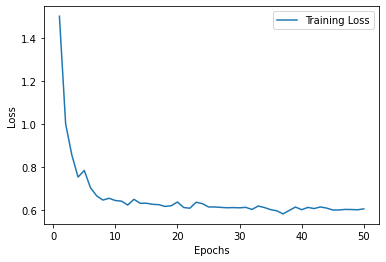

In [45]:
loss_values = lstmhistory.history['loss']
epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

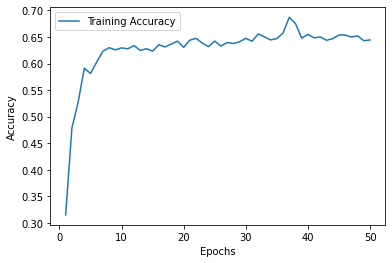

In [46]:
acc_values = lstmhistory.history['accuracy']
epochs = range(1, len(loss_values)+1)

plt.plot(epochs, acc_values, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

[4 5 5 ... 1 1 1]
[4. 4. 4. ... 1. 1. 1.]


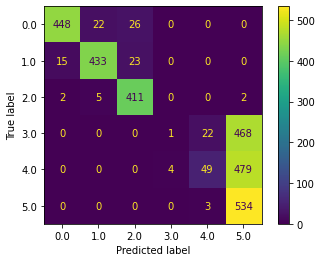

In [47]:
y_pred = np.argmax(lstm.predict(X_xyz_norm_test),axis=1)
print(y_pred)
# print(y_pred.shape)
# y_test_1D = np.argmax(y_test, axis=1).T[0]
# print(type(y_test_1D))
print(y_test)
# print(y_test_1D.shape)
ConfusionMatrixDisplay.from_predictions(y_test,y_pred)

In [48]:
# %tensorboard --logdir logs/fit/lstm/

To run tensorboard in the cli use command ```tensorboard --logdir logs/fit/lstm/```

<H1>Implementing Bidirectional LSTM</H1>

In [49]:
# Bidirectional LSTM

bidirectional_lstm = models.Sequential()
bidirectional_lstm.add(layers.Bidirectional(
    layers.LSTM(128),input_shape=input_shape
))
bidirectional_lstm.add(layers.Dropout(rate=0.2))
bidirectional_lstm.add(layers.Dense(6,activation="softmax"))

In [50]:
bidirectional_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 256)              135168    
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 6)                 1542      
                                                                 
Total params: 136,710
Trainable params: 136,710
Non-trainable params: 0
_________________________________________________________________


In [51]:
bidirectional_lstm.compile(optimizer = "adam",
            loss="categorical_crossentropy",
            metrics = "accuracy"
            )

In [52]:
bidirectional_lstm_log_dir = "logs/fit/lstm/bidirectional" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
bidirectional_lstm_tensorboard_callback = TensorBoard(log_dir=lstm_log_dir, histogram_freq=1)

In [53]:
lstmhistory = lstm.fit(X_xyz_norm_train,y_ohe_train,epochs = 50,batch_size=10,validation_data=(X_xyz_norm_test, y_ohe_test),callbacks=[bidirectional_lstm_tensorboard_callback])

Epoch 1/50
736/736 [==============================] - 7s 10ms/step - loss: 0.6066 - accuracy: 0.6378 - val_loss: 0.8243 - val_accuracy: 0.6556
Epoch 2/50
736/736 [==============================] - 7s 10ms/step - loss: 0.5944 - accuracy: 0.6655 - val_loss: 0.8270 - val_accuracy: 0.6552
Epoch 3/50
736/736 [==============================] - 7s 10ms/step - loss: 0.5786 - accuracy: 0.6770 - val_loss: 0.8267 - val_accuracy: 0.7065
Epoch 4/50
736/736 [==============================] - 7s 10ms/step - loss: 0.5433 - accuracy: 0.7153 - val_loss: 0.8515 - val_accuracy: 0.6949
Epoch 5/50
736/736 [==============================] - 7s 10ms/step - loss: 0.5314 - accuracy: 0.7266 - val_loss: 0.8219 - val_accuracy: 0.7027
Epoch 6/50
736/736 [==============================] - 7s 10ms/step - loss: 0.5994 - accuracy: 0.6710 - val_loss: 0.9009 - val_accuracy: 0.6705
Epoch 7/50
736/736 [==============================] - 7s 10ms/step - loss: 0.6019 - accuracy: 0.6663 - val_loss: 0.7706 - val_accuracy: 0.6043

In [54]:
end = time.perf_counter()
print(f"notebook took {end - start:0.4f} seconds to finish")

notebook took 835.4368 seconds to finish
